# Light GBM modeling

This version has improvements based on new feature engg techniques observed from different kernels. Below are few of them:
- https://www.kaggle.com/graf10a/lightgbm-lb-0-9675
- https://www.kaggle.com/rteja1113/lightgbm-with-count-features?scriptVersionId=2815638
- https://www.kaggle.com/nuhsikander/lgbm-new-features-corrected?scriptVersionId=2852561
- https://www.kaggle.com/aloisiodn/lgbm-starter-early-stopping-0-9539 (Original script)
---
**ここからコピー・改変**  
https://www.kaggle.com/pranav84/lightgbm-fixing-unbalanced-data-lb-0-9680/code

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import psycopg2
import lightgbm as lgb
import json
import time
import gc
%matplotlib inline

In [2]:
path = '../../data/'
dtypes = {
    'id'                : 'uint32',
    'click_id'          : 'float32',
    'ip'                : 'uint32',
    'app'               : 'uint16',
    'device'            : 'uint16',
    'os'                : 'uint16',
    'channel'           : 'uint16',
    'is_attributed'     : 'uint8',
    'is_test'           : 'uint8',
    'uq_user'           : 'uint32',
    'app_pre'           : 'float16',
    'app_post'          : 'float16',
    'same_app_pre'      : 'bool',
    'same_app_post'     : 'bool',
    'chan_pre'          : 'float16',
    'chan_post'         : 'float16',
    'same_ch_pre'       : 'bool',
    'same_ch_post'      : 'bool',
    'interval_pre'      : 'float16',
    'interval_post'     : 'float16',
    'click_hour'        : 'uint8',
    'cnt_day'           : 'uint32',
    'cnt_1hour'         : 'uint16',
    'cnt_30min'         : 'uint16',
    'cnt_15min'         : 'uint16',
    'cnt_10min'         : 'uint16',
    'cnt_5min'          : 'uint16',
    'cnt_1min'          : 'uint16'
}

In [3]:
def lgb_modelfit_nocv(params,
                      dtrain,
                      dvalid,
                      predictors,
                      target='target',
                      objective='binary',
                      metrics='auc',
                      feval=None,
                      early_stopping_rounds=20,
                      num_boost_round=3000,
                      verbose_eval=10,
                      categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.01,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    n_estimators = bst1.best_iteration
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics+":", evals_results['valid'][metrics][n_estimators-1])

    return bst1

In [14]:
%%time
path = '../../data/'
train = pd.read_csv(path + 'train_mod' + '.csv', dtype=dtypes, nrows=1000)
print(train.shape)

(10000000, 29)
CPU times: user 21.3 s, sys: 676 ms, total: 21.9 s
Wall time: 21.9 s


In [17]:
pd.set_option('display.max_columns', 500)
print(train.head())

          id  click_id  ip  app  device  os  channel  is_attributed  is_test  \
0  144482172       NaN   1    2       1   2      477              0        0   
1  146120513       NaN   1    2       1   2      477              0        0   
2  146134295       NaN   1    2       1   2      477              0        0   
3  147103437       NaN   1    2       1   2      477              0        0   
4  160258098       NaN   1    2       1   2      477              0        0   

         click_time_ch   uq_user  app_pre  app_post  same_app_pre  \
0  2017-11-09 01:47:39  10020001      NaN       2.0         False   
1  2017-11-09 04:08:39  10020001      2.0       2.0          True   
2  2017-11-09 04:10:32  10020001      2.0       2.0          True   
3  2017-11-09 06:03:35  10020001      2.0       2.0          True   
4  2017-11-09 11:01:59  10020001      2.0      14.0          True   

   same_app_post  chan_pre  chan_post  same_ch_pre  same_ch_post  \
0           True       NaN      477.

In [5]:
train['same_ch_pre'].head()

0    False
1     True
2     True
3     True
4     True
Name: same_ch_pre, dtype: bool

In [6]:
np.max(train['interval_pre'])

59.0

In [7]:
train.dtypes

id                uint32
click_id         float32
ip                uint32
app               uint16
device            uint16
os                uint16
channel           uint16
is_attributed      uint8
is_test            uint8
click_time_ch     object
uq_user           uint32
app_pre          float16
app_post         float16
same_app_pre        bool
same_app_post       bool
chan_pre         float16
chan_post        float16
same_ch_pre         bool
same_ch_post        bool
interval_pre     float16
interval_post    float16
click_hour         uint8
cnt_day           uint32
cnt_1hour         uint16
cnt_30min         uint16
cnt_15min         uint16
cnt_10min         uint16
cnt_5min          uint16
cnt_1min          uint16
dtype: object

In [8]:
# test_df = merge[merge.is_test == 1]
# train_df = merge[(merge.is_test == 0) & (merge.click_date != '2017-11-09 00:00:00')]
# val_df = merge[(merge.is_test == 0) & (merge.click_date == '2017-11-09 00:00:00')]

train_df = train[train.click_time_ch < '2017-11-09 00:00:00']
val_df = train[train.click_time_ch >= '2017-11-09 00:00:00']

print(train_df.shape, val_df.shape)
# del train
# print(test_df.shape, train_df.shape, val_df.shape)
# del merge

(6590244, 29) (3409756, 29)


In [9]:
del train
gc.collect()

26

In [10]:
target = 'is_attributed'
predictors = ['device', 'os', 
              'app','app_pre', 'app_post', 'same_app_pre', 'same_app_post',
              'channel','chan_pre', 'chan_post', 'same_ch_pre', 'same_ch_post',
              'click_hour', 'cnt_1hour', 'cnt_15min', 'cnt_1min']
categorical = ['device', 'os',
               'app','app_pre', 'app_post', 'same_app_pre', 'same_app_post',
               'channel', 'chan_pre', 'chan_post', 'same_ch_pre', 'same_ch_post']
# sub = pd.DataFrame()
# sub['click_id'] = test_df['click_id'].astype('int')

gc.collect()

0

In [11]:
print("Training...")
start_time = time.time()

params = {
    'learning_rate': 0.15,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':99 # because training data is extremely unbalanced 
}
bst = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=30, 
                        verbose_eval=True, 
                        num_boost_round=500, 
                        categorical_features=categorical)

print('[{}]: model training time'.format(time.time() - start_time))
del train_df
del val_df
gc.collect()

Training...
preparing validation datasets


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.946504	valid's auc: 0.924534
[20]	train's auc: 0.952302	valid's auc: 0.929473
[30]	train's auc: 0.957682	valid's auc: 0.933459
[40]	train's auc: 0.961927	valid's auc: 0.935937
[50]	train's auc: 0.964859	valid's auc: 0.936778
[60]	train's auc: 0.967012	valid's auc: 0.936956
[70]	train's auc: 0.968843	valid's auc: 0.937376
[80]	train's auc: 0.970448	valid's auc: 0.937305
[90]	train's auc: 0.972015	valid's auc: 0.937224
[100]	train's auc: 0.973229	valid's auc: 0.937285
[110]	train's auc: 0.974523	valid's auc: 0.937284
Early stopping, best iteration is:
[85]	train's auc: 0.971298	valid's auc: 0.937554

Model Report
n_estimators :  85
auc: 0.9375538645447843
[115.28331804275513]: model training time


80

In [13]:
print(train_df.head())

NameError: name 'train_df' is not defined

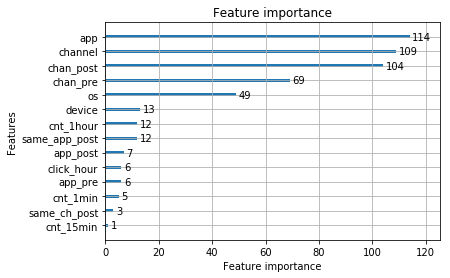

In [12]:
lgb.plot_importance(bst)

print("Predicting...")
sub['is_attributed'] = bst.predict(test_df[predictors])
print("writing...")
sub.to_csv('sub_lgb_balanced99.csv',index=False)
print("done...")